Add imports, define variables and load the dataset

In [424]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.mps.manual_seed(0)
np.random.seed(0)

BATCH_SIZE = 64
LOOKBACK_LENGTH = 365
TEST_LENGTH = 365
DROPOUT = 0.2
HIDDEN_SIZE = 128
NUM_LAYERS = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001
EPOCHS = 125

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and sort the data
data = pd.read_csv("../data/BTC Data 2013-12-27 2025-04-01.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

print(f"Data range: {data['date'].min()} to {data['date'].max()}")
print(f"Total samples: {len(data)}")

Using device: cuda
Data range: 2013-12-27 00:00:00 to 2025-04-01 00:00:00
Total samples: 4114


Add extra features for cyclic trends in the Bitcoin history

In [425]:
data['dayOfWeek'] = data['date'].dt.dayofweek
data['dayOfMonth'] = data['date'].dt.day
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter
data['isWeekend'] = data['dayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

Normalize the dataset

In [426]:
feature_columns = ['open', 'high', 'low', 'volume', 'marketCap', 'meanTxFee',
				  'txCnt', 'activeAddressCnt', 'hashRate', 'difficulty', 'revenuePerHash',
				  'dayOfWeek', 'dayOfMonth', 'month', 'quarter', 'isWeekend']
target_column = 'close'

X = data[feature_columns].values
y = data[target_column].values.reshape(-1, 1)

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = X_scaler.fit_transform(X)
y_normalized = y_scaler.fit_transform(y)

Create custom dataset with the timeseries sequences

In [427]:
class TimeSeriesDataset(Dataset):
	def __init__(self, X, y):
		self.X = torch.FloatTensor(X)
		self.y = torch.FloatTensor(y)

	def __len__(self):
		return len(self.X)

	def __getitem__(self, i):
		return self.X[i], self.y[i]

def create_sequences(X, y, seq_length):
	X_seq, y_seq = [], []
	
	for i in range(len(X) - seq_length):
		X_seq.append(X[i:i + seq_length])
		y_seq.append(y[i + seq_length])
		
	return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_normalized, y_normalized, LOOKBACK_LENGTH)

test_dates = data['date'].iloc[-TEST_LENGTH:]

train_dataset = TimeSeriesDataset(X_seq[:-TEST_LENGTH], y_seq[:-TEST_LENGTH])
test_dataset = TimeSeriesDataset(X_seq[-TEST_LENGTH:], y_seq[-TEST_LENGTH:])

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Train samples: 3384
Test samples: 365


Create the model

In [428]:
class LSTMPrediction(nn.Module):
	def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=DROPOUT):
		super(LSTMPrediction, self).__init__()

		self.hidden_size = hidden_size
		self.num_layers = num_layers
		
		self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)

		self.fc = nn.Linear(hidden_size, output_size)

	def forward(self, x):
		output, _ = self.lstm(x)
		output = self.fc(output[:, -1, :])
		return output

model = LSTMPrediction(len(feature_columns), HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE, DROPOUT).to(device)
print(model)

LSTMPrediction(
  (lstm): LSTM(16, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


Define loss function and training function with Adam optimizer

In [429]:
def train(model, train_loader, criterion, optimizer, epochs=EPOCHS):
	train_losses = []

	for epoch in range(epochs):
		model.train()
		train_loss = 0
		for X_batch, y_batch in train_loader:
			X_batch = X_batch.to(device)
			y_batch = y_batch.to(device)
			
			# Predict the output
			y_pred = model(X_batch)
			loss = criterion(y_pred, y_batch)

			# Reset gradients, calculate new ones and update model parameters
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			train_loss += loss.item()

		train_loss /= len(train_loader)
		train_losses.append(train_loss)
		print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.6f}")

	return model, train_losses

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

model, train_losses = train(model, train_loader, criterion, optimizer, EPOCHS)

Epoch 1/125, Train Loss: 0.055708
Epoch 2/125, Train Loss: 0.002135
Epoch 3/125, Train Loss: 0.001520
Epoch 4/125, Train Loss: 0.001381
Epoch 5/125, Train Loss: 0.001313
Epoch 6/125, Train Loss: 0.001209
Epoch 7/125, Train Loss: 0.001092
Epoch 8/125, Train Loss: 0.001066
Epoch 9/125, Train Loss: 0.001050
Epoch 10/125, Train Loss: 0.000962
Epoch 11/125, Train Loss: 0.000938
Epoch 12/125, Train Loss: 0.000984
Epoch 13/125, Train Loss: 0.000850
Epoch 14/125, Train Loss: 0.000878
Epoch 15/125, Train Loss: 0.000815
Epoch 16/125, Train Loss: 0.000789
Epoch 17/125, Train Loss: 0.000824
Epoch 18/125, Train Loss: 0.000776
Epoch 19/125, Train Loss: 0.000780
Epoch 20/125, Train Loss: 0.000821
Epoch 21/125, Train Loss: 0.000749
Epoch 22/125, Train Loss: 0.000691
Epoch 23/125, Train Loss: 0.000722
Epoch 24/125, Train Loss: 0.000685
Epoch 25/125, Train Loss: 0.000681
Epoch 26/125, Train Loss: 0.000657
Epoch 27/125, Train Loss: 0.000678
Epoch 28/125, Train Loss: 0.000687
Epoch 29/125, Train Loss: 0.0

In [433]:
torch.save(model.state_dict(), f"../weights/od_lstm-{NUM_LAYERS}l-{HIDDEN_SIZE}hs-{DROPOUT}d-{LOOKBACK_LENGTH}lb-{EPOCHS}e-all.pth")

Evaluate the model

In [434]:
def evaluate(model, test_loader, criterion):
	model.eval()
	test_loss = 0
	predictions = []
	truths = []

	with torch.no_grad():
		for X_batch, y_batch in test_loader:
			X_batch = X_batch.to(device)
			y_batch = y_batch.to(device)
			
			y_pred = model(X_batch)
			loss = criterion(y_pred, y_batch)

			test_loss += loss.item()

			# Add the predicted and actual values for plotting
			# Move to the CPU and convert the tensor to a numpy array
			predictions.append(y_pred.cpu().numpy())
			truths.append(y_batch.cpu().numpy())

	test_loss /= len(test_loader)

	predictions = np.concatenate(predictions, axis=0)
	truths = np.concatenate(truths, axis=0)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))

	print(f"Train Loss: {train_losses[-1]:.6f}")
	print(f"Test Loss: {test_loss:.6f}")

	print("\nNormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	# Inverse the normalization to get the actual BTC prices
	predictions = y_scaler.inverse_transform(predictions)
	truths = y_scaler.inverse_transform(truths)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))
	print("\nUnnormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	return predictions, truths

predictions, actuals = evaluate(model, test_loader, criterion)


Train Loss: 0.000301
Test Loss: 0.040163

Normalized
MSE: 0.039882
RMSE: 0.199704
MAE: 0.144434
MAPE: 0.326599

Unnormalized
MSE: 111960056.000000
RMSE: 10581.118164
MAE: 7652.685547
MAPE: 0.087410


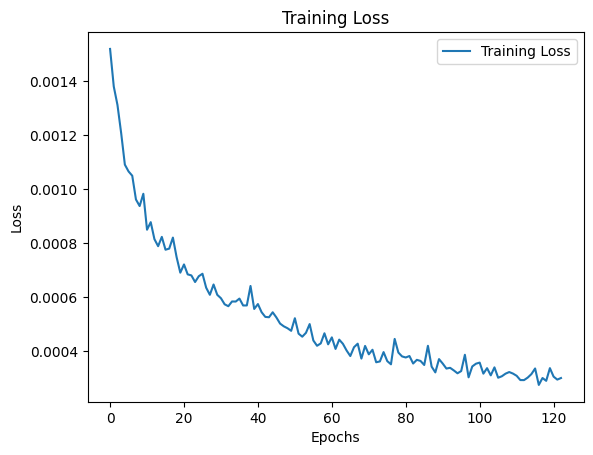

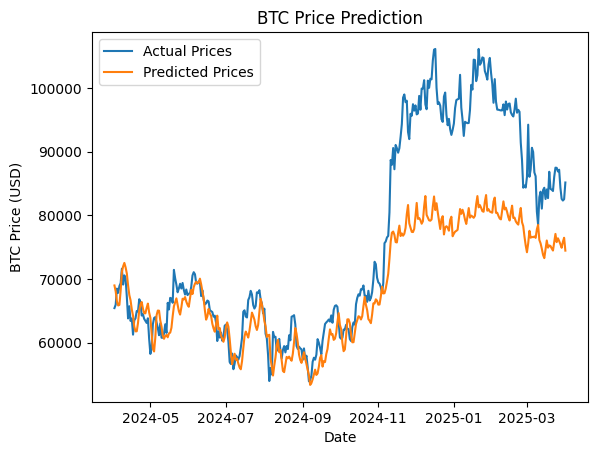

In [435]:
plt.plot(train_losses[2:], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

plt.plot(test_dates, actuals, label='Actual Prices')
plt.plot(test_dates, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()